## Past this header the code was provided by the team's GitHub

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [143]:
batch1 = pickle.load(open(r'./batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [144]:
numBat1 = len(batch1.keys())
numBat1

41

In [145]:
batch2 = pickle.load(open(r'./batch2.pkl','rb'))

In [146]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [147]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [148]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [149]:
numBat2 = len(batch2.keys())
numBat2

43

In [150]:
batch3 = pickle.load(open(r'./batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [151]:
numBat3 = len(batch3.keys())
numBat3

40

In [152]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [153]:
bat_dict = {**batch1, **batch2, **batch3}

Text(0, 0.5, 'Discharge Capacity (Ah)')

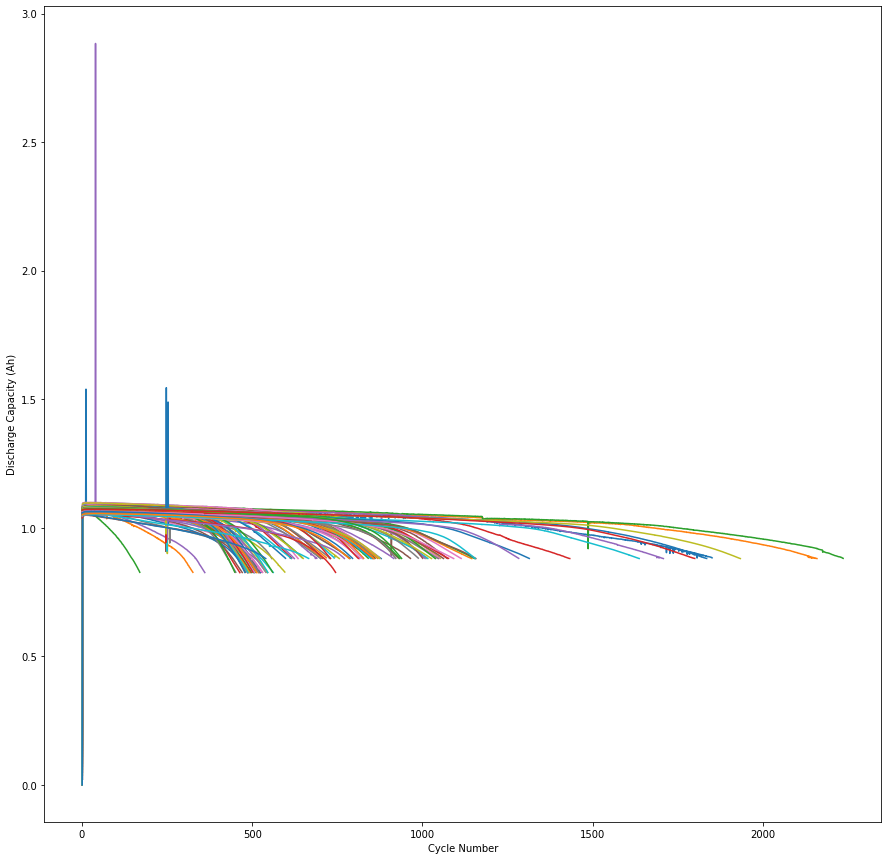

In [154]:
plt.figure(figsize=(15,15))
for i in bat_dict.keys():
    plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

### Train and Test Split
If you are interested in using the same train/test split as the paper, use the indices specified below

In [155]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);
(test_ind,train_ind)

(array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]),
 array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]))

# Bellow is my work
I will be recreating the 'Variance' prediction model and measure their corresponding Root Mean Squared Error and Mean percent error (%). First I define some uselful functions:

In [156]:
def rmse(y,y_predict):
    assert np.shape(y_predict)[0]!=0
    assert np.shape(y_predict) == np.shape(y)
    n = np.shape(y_predict)[0]
    return np.sqrt((1/n)*np.sum((y_predict-y)**2))

def mean_error(y,y_predict):
    assert np.shape(y_predict)==np.shape(y)
    assert np.shape(y_predict)[0]!=0
    n = np.shape(y_predict)[0]
    return (1/n)*np.sum(np.abs(y_predict-y)/y)*100

def errors_summary(X_train,X_test1,X_test2,y_train,y_test1,y_test2,model):
    """Returns the lists of RMSE and Percentage Mean errors against the tests
       and the training sets"""
    RMSEs = [rmse(y_train,model.predict(X_train)),
         rmse(y_test1,model.predict(X_test1)),
         rmse(y_test2,model.predict(X_test2))]
    Mean_errors = [mean_error(y_train,model.predict(X_train)),
               mean_error(y_test1,model.predict(X_test1)),
               mean_error(y_test2,model.predict(X_test2))]
    return RMSEs, Mean_errors

## Creating the dataset $\;\mathcal{D} = \{x_i,y_i\}_{i=1}^n = \{X,y\}$

In [157]:
bats = list(bat_dict.keys())

# Creating output vector
y = np.array([])
for bat in bats:
    life_cycle = np.array(bat_dict[bat]['cycle_life'][0])
    y = np.concatenate((y,life_cycle),axis=0)

# Creating data matrix
# Features: log(var(dQ_{100-10})),log(min(|dQ_{100-10}|)),dT_{100-10}
X = np.array([[0]])
dQ = np.array([])
for bat in bats:
    assert np.shape(bat_dict[bat]['cycles']['10']['Qdlin'])==np.shape(bat_dict[bat]['cycles']['100']['Qdlin'])
    
    delta_Q =bat_dict[bat]['cycles']['100']['Qdlin']-bat_dict[bat]['cycles']['10']['Qdlin']
    max_dTemp = np.max(np.abs(bat_dict[bat]['cycles']['100']['Tdlin']-bat_dict[bat]['cycles']['10']['Tdlin']))
    X = np.concatenate((X,np.array([[np.log(np.var(delta_Q))]])),axis=0)
    
X_train, y_train = X[train_ind+1,:], y[train_ind]
X_test1, y_test1 = X[test_ind+1,:], y[test_ind]
X_test2, y_test2 = X[secondary_test_ind+1,:], y[secondary_test_ind]

## RMSEs and %errors of LR ##
Training:	 RMSE: 151.66533014676085 	 %error: 21.615413670984648
1st Test:	 RMSE: 166.80050673456387 	 %error: 22.23293752074045
2nd Test:	 RMSE: 208.54617342209048 	 %error: 13.423838267853602
Overall:	 RMSE: 175.6706701011384 	 %error: 19.09072981985957


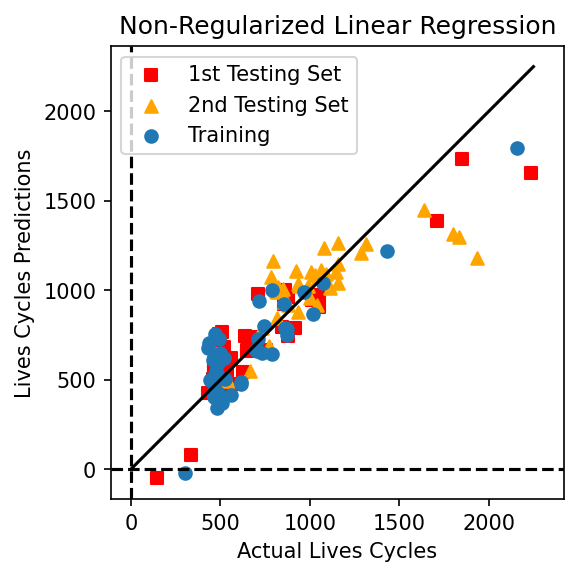

In [159]:
import sklearn.linear_model as lm

## Linear Regression
# Basic linear regression fitting
model = lm.LinearRegression(fit_intercept=True)
model.fit(X_train,y_train)

# Fitting and plotting Linear Regression model
plt.figure(1,dpi=150)
plt.plot(np.linspace(1,2250),np.linspace(1,2250),color='black',linestyle="-")
plt.scatter(y_test1,model.predict(X_test1),marker ='s',color="red",label='1st Testing Set')
plt.scatter(y_test2,model.predict(X_test2),marker ='^',color="orange", label ='2nd Testing Set')
plt.scatter(y_train,model.predict(X_train),label="Training")
plt.xlabel("Actual Lives Cycles")
plt.ylabel("Lives Cycles Predictions")
plt.title("Non-Regularized Linear Regression")
plt.axis('square')
plt.axvline(x=0, c="black", linestyle='--')
plt.axhline(y=0, c="black", linestyle='--')
plt.legend()
plt.savefig("non_regularized_lr.png");

# Printing RMSEs and %errors
RMSEs, Mean_errors = errors_summary(X_train,X_test1,X_test2,y_train,y_test1,y_test2,model)

print('## RMSEs and %errors of LR ##')
print('Training:\t RMSE: {} \t %error: {}'.format(RMSEs[0],Mean_errors[0]))
print('1st Test:\t RMSE: {} \t %error: {}'.format(RMSEs[1],Mean_errors[1]))
print('2nd Test:\t RMSE: {} \t %error: {}'.format(RMSEs[2],Mean_errors[2]))
print('Averaged:\t RMSE: {} \t %error: {}'.format(np.mean(RMSEs),np.mean(Mean_errors)))

In [135]:
#GridSearch had warning due to the slow convergence of cv search
#I removed the warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV


## Elastic Net
# ElasticNet GridSearch when I will have more parameters
params = {'alpha': 10**np.linspace(-1, 0, 200)}
grid_search = GridSearchCV(ElasticNet(), params, scoring = "neg_root_mean_squared_error")
grid_search.fit(X_train, y_train)

# Use this to determine the best hyperparameter to use in ElasticNet
Alpha = grid_search.best_estimator_
best_rmse = -grid_search.best_score_
print("Best alpha: {}\t Best score (RMSE): {}".format(Alpha,best_rmse))

Best alpha: ElasticNet(alpha=0.1)	 Best score (RMSE): 193.66742504314567


Training:	 RMSE: 152.77815722664977 	 %error: 20.873663163995868
1st Test:	 RMSE: 172.38250265699548 	 %error: 21.42716541093361
2nd Test:	 RMSE: 212.1460763238242 	 %error: 12.679407106972986
Overall:	 RMSE: 179.10224540248984 	 %error: 18.326745227300822


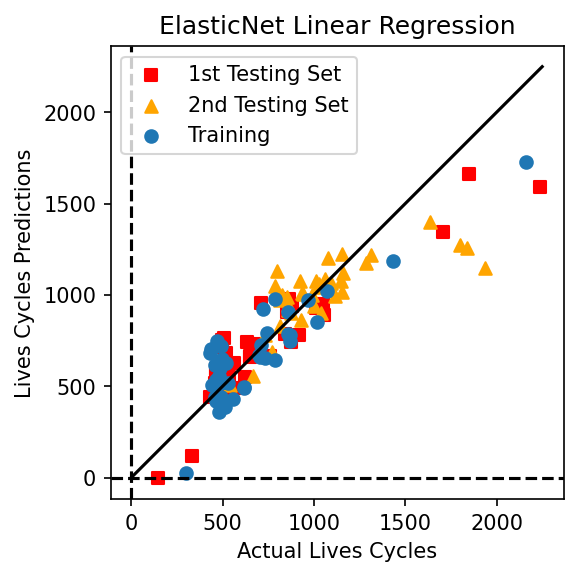

In [160]:
# Fitting and plotting
eln_model = ElasticNet(alpha=0.1, fit_intercept=True, random_state = 0)
eln_model.fit(X_train,y_train)

plt.figure(2,dpi=150)
plt.plot(np.linspace(1,2250),np.linspace(1,2250),color='black',linestyle="-")
plt.scatter(y_test1,eln_model.predict(X_test1),marker ='s',color="red",label='1st Testing Set')
plt.scatter(y_test2,eln_model.predict(X_test2),marker ='^',color="orange", label ='2nd Testing Set')
plt.scatter(y_train,eln_model.predict(X_train),label="Training")
plt.xlabel("Actual Lives Cycles")
plt.ylabel("Lives Cycles Predictions")
plt.title("ElasticNet Linear Regression")
plt.axis('square')
plt.axvline(x=0, c="black", linestyle='--')
plt.axhline(y=0, c="black", linestyle='--')
plt.legend()
plt.savefig("elasticNet_lr.png");


# Printing RMSEs and %errors
RMSEs, Mean_errors = errors_summary(X_train,X_test1,X_test2,y_train,y_test1,y_test2,eln_model)

print('Training:\t RMSE: {} \t %error: {}'.format(RMSEs[0],Mean_errors[0]))
print('1st Test:\t RMSE: {} \t %error: {}'.format(RMSEs[1],Mean_errors[1]))
print('2nd Test:\t RMSE: {} \t %error: {}'.format(RMSEs[2],Mean_errors[2]))
print('Averaged:\t RMSE: {} \t %error: {}'.format(np.mean(RMSEs),np.mean(Mean_errors)))